# Homework 2

**Name**: **Charles Zhang**

**UID**: **305-413-659**

Note: Please remember to make a copy of this colab notebook in your drive.

In [1]:
# Download a processed version of the data
!wget https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt

--2022-11-16 07:29:13--  https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt
Resolving web.cs.ucla.edu (web.cs.ucla.edu)... 131.179.128.29
Connecting to web.cs.ucla.edu (web.cs.ucla.edu)|131.179.128.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1264848 (1.2M) [text/plain]
Saving to: ‘mushroom.txt’

mushroom.txt        100%[===================>]   1.21M  4.13MB/s    in 0.3s    

2022-11-16 07:29:14 (4.13 MB/s) - ‘mushroom.txt’ saved [1264848/1264848]



In [3]:
# Use only the provided packages!
import csv
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# load data from txt
# X.shape = (n_examples, n_features), y.shape = (n_examples, )
def load_data(filename):
    data = pandas.read_csv(filename).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1

    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'EDIBLE': 1, 'POISONOUS': 0}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]

    # We only use these 6 features
    features = [0, 2, 8, 10, 15, 17]
    X = np.take(X, features, axis=-1)

    return X, y

In [4]:
def create_data(filename, test_size=0.15, val_size=0.15):
    # Load the dataset
    X, y = load_data(filename='mushroom.txt')

    # Split into train, validation, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    X_train, X_val, X_test = torch.Tensor(X_train), torch.Tensor(X_val), torch.Tensor(X_test)
    y_train = torch.Tensor(np.array([ [y] for y in y_train ]))
    y_val = torch.Tensor(np.array([ [y] for y in y_val ]))
    y_test = torch.Tensor(np.array([ [y] for y in y_test ]))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
def get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_batch_size=16, test_batch_size=32):
    ### ========== TODO : START ========== ###
    # part a: Create dataloaders for train, validation and test sets
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=test_batch_size)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
    ### ========== TODO : END ========== ###

    return train_loader, val_loader, test_loader

In [6]:
def evaluate_loss(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    for batch_X, batch_y in dataloader:
        batch_size = len(batch_X)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()

    return total_loss / len(dataloader.dataset)

In [7]:
def evaluate_acc(model, dataloader):
    model.eval()
    total_acc = 0.0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        predictions = (outputs > 0.5).long()
        total_acc += (predictions==batch_y).sum()
        
    return total_acc / len(dataloader.dataset)

In [8]:
######################################################################
# OneLayerNetwork -- ALSO A LOGISTIC REGRESSION MODEL
######################################################################

class OneLayerNetwork(torch.nn.Module):
    def __init__(self, input_features):
        # input_features: int
        super(OneLayerNetwork, self).__init__()

        ### ========== TODO : START ========== ###
        ### part c: implement OneLayerNetwork with torch.nn.Linear. Use sigmoid as the activation
        self.linear = torch.nn.Linear(input_features, 1)
        self.sigmoid = torch.nn.Sigmoid()
        ### ========== TODO : END ========== ###

    def forward(self, x):
        # x.shape = (n_batch, n_features)

        ### ========== TODO : START ========== ###
        ### part c: implement the foward function
        x = self.linear(x)
        outputs = self.sigmoid(x)
        ### ========== TODO : END ========== ###
        return outputs



In [9]:
def init_oneLayerNN(in_features, lr):
    # input_features: int -> Number of input features
    # lr: float -> Learning Rate

    ### ========== TODO : START ========== ###
    ### part d: prepare the OneLayerNetwork model, criterion, and optimizer
    model = OneLayerNetwork(in_features)
    criterion = torch.nn.BCELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    ### ========== TODO : END ========== ###
    return model, criterion, optimizer

In [10]:
######################################################################
# TwoLayerNetwork
######################################################################

class TwoLayerNetwork(torch.nn.Module):
    def __init__(self, input_features, hidden_features, first_activation='sigmoid'):
        # input_features: int -> Number of input features
        # hidden_features: int -> Size of the hidden layer
        # first_activation: str -> Activation to use for the first hidden layer
        
        super(TwoLayerNetwork, self).__init__()
        ### ========== TODO : START ========== ###
        ### part e: implement TwoLayerNetwork with torch.nn.Linear. Use sigmoid as the activation for both layers
        self.linear1 = torch.nn.Linear(input_features, hidden_features)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.linear2 = torch.nn.Linear(hidden_features, 1)
        self.sigmoid2 = torch.nn.Sigmoid()
        ### ========== TODO : END ========== ###

    def forward(self, x):
        # x.shape = (n_batch, n_features)

        ### ========== TODO : START ========== ###
        ### part e: implement the foward function
        x = self.linear1(x)
        x = self.sigmoid1(x)
        x = self.linear2(x)
        outputs = self.sigmoid2(x)
        ### ========== TODO : END ========== ###
        return outputs

In [11]:
def init_twoLayerNN(in_features, hidden_size, first_activation, lr):
    # input_features: int -> Number of input features
    # hidden_features: int -> Size of the hidden layer
    # first_activation: str -> Activation to use for the first hidden layer
    # lr: float -> Learning Rate

    ### ========== TODO : START ========== ###
    ### part f: prepare the TwoLayerNetwork model, criterion, and optimizer
    model = TwoLayerNetwork(in_features, hidden_size, first_activation)
    criterion = torch.nn.BCELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    ### ========== TODO : END ========== ###

    return model, criterion, optimizer

In [12]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, logging_epochs=1):
    print("Start training model...")

    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    for epoch in range(1, num_epochs+1):
        model.train()
        for batch_X, batch_y in train_loader:
            ### ========== TODO : START ========== ###
            ### part g: Build the training paradigm - Zero out gradients, forward pass, compute loss, loss backward, update model
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            ### ========== TODO : END ========== ###
            
        train_loss = evaluate_loss(model, criterion, train_loader)
        valid_loss = evaluate_loss(model, criterion, valid_loader)
        train_acc = evaluate_acc(model, train_loader)
        valid_acc = evaluate_acc(model, valid_loader)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

        if logging_epochs > 0 and epoch % logging_epochs == 0:
            print(f"| epoch {epoch:2d} | train loss {train_loss:.6f} | train acc {train_acc:.6f} | valid loss {valid_loss:.6f} | valid acc {valid_acc:.6f} |")

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

In [13]:
# fix random seed
np.random.seed(42)
torch.manual_seed(42)

In [14]:
# Data Preparation
train_batch_size = 16
test_batch_size = 32

## Load data
X_train, y_train, X_val, y_val, X_test, y_test = create_data("mushroom.txt")

## Create data loaders
train_loader, val_loader, test_loader = get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_batch_size=train_batch_size, test_batch_size=test_batch_size)

In [15]:
## Define hyperparameters
lr = 0.001
num_epochs = 50

## Init models
oneLayerNN, criterion, optimizer = init_oneLayerNN(X_train.shape[1], lr=lr)
results_one = train(oneLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Start training model...
| epoch  1 | train loss 0.546384 | train acc 0.732357 | valid loss 0.545550 | valid acc 0.739049 |
| epoch  2 | train loss 0.537560 | train acc 0.755881 | valid loss 0.539040 | valid acc 0.760485 |
| epoch  3 | train loss 0.533699 | train acc 0.761309 | valid loss 0.536818 | valid acc 0.767008 |
| epoch  4 | train loss 0.530968 | train acc 0.759829 | valid loss 0.535419 | valid acc 0.762349 |
| epoch  5 | train loss 0.528757 | train acc 0.757032 | valid loss 0.534337 | valid acc 0.760485 |
| epoch  6 | train loss 0.526884 | train acc 0.757526 | valid loss 0.533437 | valid acc 0.759553 |
| epoch  7 | train loss 0.525260 | train acc 0.757526 | valid loss 0.532658 | valid acc 0.759553 |
| epoch  8 | train loss 0.523823 | train acc 0.757526 | valid loss 0.531960 | valid acc 0.759553 |
| epoch  9 | train loss 0.522533 | train acc 0.759006 | valid loss 0.531317 | valid acc 0.760485 |
| epoch 10 | train loss 0.521359 | train acc 0.759006 | valid loss 0.530715 | valid a

In [16]:
## Define hyperparameters
lr = 0.001
hidden_size = 6
activation = 'sigmoid'
num_epochs = 50

## Init models
twoLayerNN, criterion, optimizer = init_twoLayerNN(X_train.shape[1], hidden_size, activation, lr=lr)
results_two = train(twoLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Start training model...
| epoch  1 | train loss 0.667682 | train acc 0.562593 | valid loss 0.668011 | valid acc 0.565704 |
| epoch  2 | train loss 0.652090 | train acc 0.623458 | valid loss 0.651769 | valid acc 0.638397 |
| epoch  3 | train loss 0.635221 | train acc 0.650271 | valid loss 0.634644 | valid acc 0.654240 |
| epoch  4 | train loss 0.615841 | train acc 0.699457 | valid loss 0.615277 | valid acc 0.697111 |
| epoch  5 | train loss 0.594264 | train acc 0.724461 | valid loss 0.593729 | valid acc 0.729730 |
| epoch  6 | train loss 0.573040 | train acc 0.728409 | valid loss 0.572476 | valid acc 0.733458 |
| epoch  7 | train loss 0.554806 | train acc 0.759993 | valid loss 0.554384 | valid acc 0.764212 |
| epoch  8 | train loss 0.539843 | train acc 0.759006 | valid loss 0.539684 | valid acc 0.765144 |
| epoch  9 | train loss 0.527671 | train acc 0.763283 | valid loss 0.527856 | valid acc 0.769804 |
| epoch 10 | train loss 0.517604 | train acc 0.763283 | valid loss 0.518233 | valid a

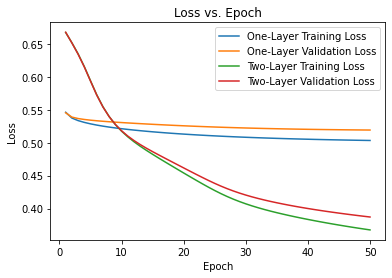

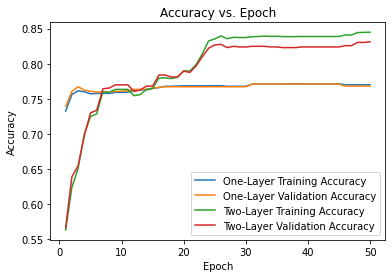

In [48]:
one_train_loss, one_valid_loss, one_train_acc, one_valid_acc = results_one
two_train_loss, two_valid_loss, two_train_acc, two_valid_acc = results_two

### ========== TODO : START ========== ###
### part h: Plot the loss for training/validation for both the models on the same curve
epochs = list(range(1, num_epochs + 1))
plt.plot(epochs, one_train_loss, label = 'One-Layer Training Loss')
plt.plot(epochs, one_valid_loss, label = 'One-Layer Validation Loss')
plt.plot(epochs, two_train_loss, label = 'Two-Layer Training Loss')
plt.plot(epochs, two_valid_loss, label = 'Two-Layer Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()
### ========== TODO : END ========== ###

### ========== TODO : START ========== ###
### part h: Plot the accuracies for training/validation for both the models on the same curve
plt.plot(epochs, one_train_acc, label = 'One-Layer Training Accuracy')
plt.plot(epochs, one_valid_acc, label = 'One-Layer Validation Accuracy')
plt.plot(epochs, two_train_acc, label = 'Two-Layer Training Accuracy')
plt.plot(epochs, two_valid_acc, label = 'Two-Layer Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()
### ========== TODO : END ========== ###

In [18]:
### ========== TODO : START ========== ###
### part i: Evaluate the test accuracies for both the models. Explain the behavior
one_test_acc = evaluate_acc(oneLayerNN, test_loader)
two_test_acc = evaluate_acc(twoLayerNN, test_loader)
print("One-Layer NN Test Accuracy:")
print('\t-- %.3f' % one_test_acc)
print("Two-Layer NN Test Accuracy:")
print('\t-- %.3f' % two_test_acc)
### ========== TODO : END ========== ###

One-Layer NN Test Accuracy:
	-- 0.778
Two-Layer NN Test Accuracy:
	-- 0.835


In [40]:
def get_confusion_matrix(model, dataloader):
    ### ========== TODO : START ========== ###
    ### part j: Create confusion matrix for the given data loader
    y_true = []
    y_pred = []
    for batch_X, batch_y in dataloader:
        for data in batch_y.numpy():
            y_true.append(data)
        output = model(batch_X).detach().numpy()
        for data in output:
            if (data >= 0.5):
                y_pred.append(1)
            else:
                y_pred.append(0)
    cm = confusion_matrix(y_true, y_pred)
    ### ========== TODO : END ========== ###

    return cm

In [41]:
oneLayerNN_cm = get_confusion_matrix(oneLayerNN, val_loader)
twoLayerNN_cm = get_confusion_matrix(twoLayerNN, val_loader)

print ("Confusion Matrix for One Layer NN:")
print (oneLayerNN_cm)
print ("\n")
print ("Confusion Matrix for Two Layer NN:")
print (twoLayerNN_cm)

Confusion Matrix for One Layer NN:
[[358 164]
 [ 85 466]]


Confusion Matrix for Two Layer NN:
[[387 135]
 [ 46 505]]


In [43]:
### ========== TODO : START ========== ###
### part k: Hyperparameter Tuning. Write your updated hyperparameter values and show improvement for the TwoLayerNetwork

# Define hyper-parameters
lr = 0.003 # changed from 0.001
hidden_size = 6
activation = 'sigmoid'
num_epochs = 50

# Train model
myTwoLayerNN, criterion, optimizer = init_twoLayerNN(X_train.shape[1], hidden_size, activation, lr=lr)
my_results_two = train(myTwoLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)
### ========== TODO : END ========== ###

Start training model...
| epoch  1 | train loss 0.614504 | train acc 0.677414 | valid loss 0.609025 | valid acc 0.698975 |
| epoch  2 | train loss 0.557886 | train acc 0.740418 | valid loss 0.554873 | valid acc 0.748369 |
| epoch  3 | train loss 0.525582 | train acc 0.755881 | valid loss 0.524840 | valid acc 0.762349 |
| epoch  4 | train loss 0.500513 | train acc 0.772002 | valid loss 0.502049 | valid acc 0.778192 |
| epoch  5 | train loss 0.478688 | train acc 0.773153 | valid loss 0.482696 | valid acc 0.778192 |
| epoch  6 | train loss 0.460119 | train acc 0.795855 | valid loss 0.466426 | valid acc 0.794967 |
| epoch  7 | train loss 0.444461 | train acc 0.806218 | valid loss 0.452819 | valid acc 0.805219 |
| epoch  8 | train loss 0.431591 | train acc 0.810824 | valid loss 0.441741 | valid acc 0.801491 |
| epoch  9 | train loss 0.421024 | train acc 0.820694 | valid loss 0.432737 | valid acc 0.816403 |
| epoch 10 | train loss 0.412176 | train acc 0.834512 | valid loss 0.425240 | valid a

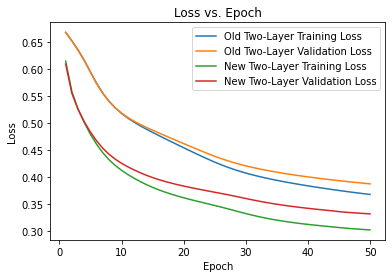

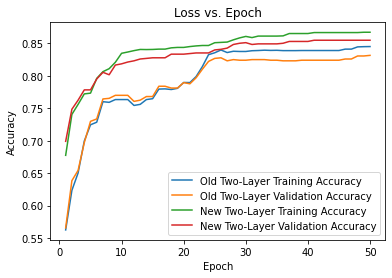

Old Two-Layer NN Test Accuracy:
	-- 0.835
New Two-Layer NN Test Accuracy:
	-- 0.866
Improvement:
	-- 0.031


In [49]:
# Define x-range
epochs = list(range(1, num_epochs + 1))
my_two_train_loss, my_two_valid_loss, my_two_train_acc, my_two_valid_acc = my_results_two

# Plot loss
plt.plot(epochs, two_train_loss, label = 'Old Two-Layer Training Loss')
plt.plot(epochs, two_valid_loss, label = 'Old Two-Layer Validation Loss')
plt.plot(epochs, my_two_train_loss, label = 'New Two-Layer Training Loss')
plt.plot(epochs, my_two_valid_loss, label = 'New Two-Layer Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

# Plot accuracies
plt.plot(epochs, two_train_acc, label = 'Old Two-Layer Training Accuracy')
plt.plot(epochs, two_valid_acc, label = 'Old Two-Layer Validation Accuracy')
plt.plot(epochs, my_two_train_acc, label = 'New Two-Layer Training Accuracy')
plt.plot(epochs, my_two_valid_acc, label = 'New Two-Layer Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

# Calculate test accuracy
my_test_acc = evaluate_acc(myTwoLayerNN, test_loader)
print("Old Two-Layer NN Test Accuracy:")
print('\t-- %.3f' % two_test_acc)
print("New Two-Layer NN Test Accuracy:")
print('\t-- %.3f' % my_test_acc)

# Calculate improvement
diff = my_test_acc.detach().numpy() - two_test_acc.detach().numpy()
print("Improvement:")
print('\t-- %.3f' % diff)